# DCGAN PYTORCH IMPLEMENTATION
Forked from here: https://github.com/pytorch/examples

In [227]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [228]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    npimg = npimg-np.amin(npimg)
    npimg = npimg/np.amax(npimg)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis("off")
        
    plt.show()

In [229]:
# We will save the results here
outf="./results_B"

In [230]:
#manualSeed = random.randint(1, 10000)
manualSeed = 4532
print("Random Seed: ", manualSeed)
random.seed(manualSeed)

torch.manual_seed(manualSeed)
cudnn.benchmark = True

use_cuda=True
if use_cuda:
    torch.cuda.manual_seed_all(manualSeed)

if torch.cuda.is_available() and not use_cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

Random Seed:  4532


You will need to download an image dataset and put them into a folder.
The "flowers" dataset, for example, can be found here:
http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Usually you need at least a few thousand images to get reasonable results
    

In [231]:
imageSize = 64 # square images for now!
dataroot = "./data_resized_B_copy"
#dataroot = "./resized_imgs"

# folder dataset
dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Scale(imageSize),
                                   transforms.CenterCrop(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))

In [232]:
batchSize= 32
workers = 2
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))

In [233]:
print('num of batches:', dataloader.__len__())
print('num Of Images:', dataloader.__len__()*batchSize)

num of batches: 102
num Of Images: 3264


In [234]:
# this example demonstrates how we can load a new batch of data
dataiter = iter(dataloader)
data= dataiter.next()
data[0]=(data[0]+1)/2
print(len(data))
print(data[0].size(),data[1].size())

2
torch.Size([32, 3, 64, 64]) torch.Size([32])


In [235]:
#labels are in data[1][:]
data[1][0:5]


 0
 0
 0
 0
 0
[torch.LongTensor of size 5]

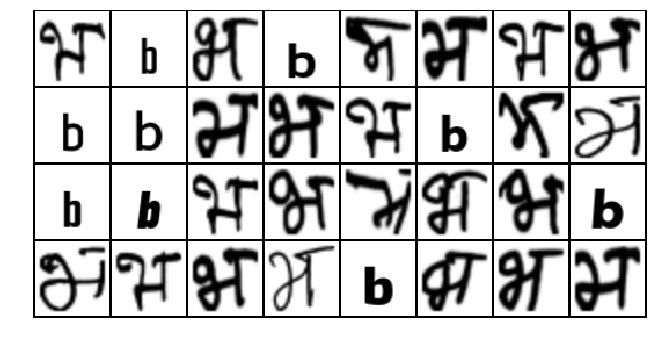

In [236]:
# show some examples from the original data
# images are in data[0][:]
show(make_grid(data[0]))


In [237]:
ngpu = int(1) # use one GPU
nz = int(100) # code dimension (This is the() random noise) input dimension of the generator network)
ngf = int(64) # output dimension of the generator network
ndf = int(64) # input dim (image size) for the discriminator net
nc = 3 # number of input channels (e.g. 3 for RGB channels)

In [238]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [239]:
# Let us create the Generator network
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [240]:
netG = _netG(ngpu)
netG.apply(weights_init)

# if we want to load a saved netG, we can do it here:
#savednetG=outf+"/netG_epoch_39.pth"
#netG.load_state_dict(torch.load(savednetG))
print(netG)


_netG(
  (main): Sequential(
    (0): ConvTranspose2d (100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [241]:
# Let us create the Discriminator network
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [242]:
netD = _netD(ngpu)
netD.apply(weights_init)

# If we want to load a saved netD, we can do it here:
#savednetD=outf+"/netD_epoch_39.pth"
#netD.load_state_dict(torch.load(savednetD))
print(netD)


_netD(
  (main): Sequential(
    (0): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d (512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [243]:
# Binary Cross Entropy between the target (p, 1-p) and the output (q,1-q) distributions
criterion = nn.BCELoss()

In [244]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize) # this will be the input of the Discriminator network

noise = torch.FloatTensor(batchSize, nz, 1, 1) # this will be the input of the Generator network

# We will also use some "fixed" noise to monitor the progess of the generated data
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)

label = torch.FloatTensor(batchSize)


In [245]:
real_label = 1
fake_label = 0

In [246]:
# put NetD, netG, the criterion, input, and noise to the GPUs
if use_cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [247]:
fixed_noise = Variable(fixed_noise)

In [248]:
# setup optimizer

beta1 =0.5
lr=0.0002

optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

#optimizerD = optim.SGD(netD.parameters(), lr=0.001, momentum=0.9)
#optimizerG = optim.SGD(netG.parameters(), lr=0.001, momentum=0.9)

## We will show one step of how to optimize NetG and NetD
Then we will put these steps into a loop

In [249]:
############################
# (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
###########################
# train with real
netD.zero_grad()
real_cpu, _ = data # data[0] = images, data[1] =labels (triangle, ellipse, rectangle). Labels are not important
batch_size = real_cpu.size(0)
if use_cuda:
    real_cpu = real_cpu.cuda() # move the image data to the GPUs
input.resize_as_(real_cpu).copy_(real_cpu) #copy the image data to input variable
print("input:", input.size())
label.resize_(batch_size).fill_(real_label) #since this is all real data add them "real_label" label
inputv = Variable(input)
labelv = Variable(label)

input: torch.Size([32, 3, 64, 64])


In [250]:
output = netD(inputv) # caclulate the predicitions of netD network:
output.size()       

torch.Size([32])

In [251]:
print(output[0:5], labelv[0:5]) # We want the predicited output to be all ones (real data)

Variable containing:
 0.5320
 0.4949
 0.1903
 0.4898
 0.2657
[torch.cuda.FloatTensor of size 5 (GPU 0)]
 Variable containing:
 1
 1
 1
 1
 1
[torch.cuda.FloatTensor of size 5 (GPU 0)]



In [252]:
# We want the output of netD(real images) to be all ones.
# Let us caclulate the error
errD_real = criterion(output, labelv)
# We want the error to be as small as possible
print("Error of Discriminator on real data: ",errD_real)

Error of Discriminator on real data:  Variable containing:
 1.1456
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [253]:

#Let D_x be the mean of the outputs on real data. 
#Since we used real data, we want D_x to be close to 1
D_x = output.data.mean()
print(D_x)

0.385009437799


In [254]:
# Let us caculate the gradient of errD_real. 
errD_real.backward()

In [255]:
# Now we will train with fake data
noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)

In [256]:
#  Generate fake images from noise
fake = netG(noisev)
fake.size()

torch.Size([32, 3, 64, 64])

In [257]:
# add "fake_label" labels to the fake images
labelv = Variable(label.fill_(fake_label))
labelv.size()

torch.Size([32])

In [258]:
output = netD(fake.detach())
output.size()

torch.Size([32])

In [259]:
#We want the output of netD(fake images) to be all zeros
print(output[0:5], labelv[0:5])

Variable containing:
 0.0589
 0.0069
 0.0204
 0.0776
 0.5935
[torch.cuda.FloatTensor of size 5 (GPU 0)]
 Variable containing:
 0
 0
 0
 0
 0
[torch.cuda.FloatTensor of size 5 (GPU 0)]



In [260]:
# Calculate the error of the Discriminiator network on the fake data
errD_fake = criterion(output, labelv)
errD_fake
# We want this error to be as small as possible

Variable containing:
 0.3080
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [261]:
# Calculate the gradient of errD_fake
errD_fake.backward()

In [262]:
#Let D_G_z1 be the mean of the output of the Discriminator on fake data
# We want D_G_z1 to be close to 0
D_G_z1 = output.data.mean()
D_G_z1

0.23536285758018494

In [263]:
# The combined error:
errD = errD_real + errD_fake
errD
# We want this to be as close to zero as possible

Variable containing:
 1.4536
[torch.cuda.FloatTensor of size 1 (GPU 0)]

 Update D network: maximize log(D(x)) + log(1 - D(G(z))) 
 We want D to be as good as possible

In [264]:
optimizerD.step()


## (2) Update G network: maximize log(D(G(z)))

In [265]:
netG.zero_grad()

In [266]:
# The Generator wants to trick the Discriminator
labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
labelv.size()

torch.Size([32])

In [267]:
output = netD(fake)
output.size()

torch.Size([32])

In [268]:
print(output[0:5], labelv[0:5]) #We want the generator the trick the Discriminator, i.e. produce all ones here!

Variable containing:
1.00000e-02 *
  3.4812
  0.3538
  1.2588
  3.4043
  8.6660
[torch.cuda.FloatTensor of size 5 (GPU 0)]
 Variable containing:
 1
 1
 1
 1
 1
[torch.cuda.FloatTensor of size 5 (GPU 0)]



In [269]:
# We want this to be as small as possible
errG = criterion(output, labelv)
errG

Variable containing:
 3.0437
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [270]:
errG.backward()

In [271]:
# We want this to be as close to one as possible (we want good fake data)
D_G_z2 = output.data.mean()
D_G_z2

0.05840244144201279

In [272]:
optimizerG.step()

Evalutation to see if netG optimizer helped

In [273]:
new_output = netD(netG(noisev))
# we want these to be all ones
new_errG = criterion(new_output, labelv)
# We want the error to be as small as possible
new_errG

Variable containing:
1.00000e-03 *
  1.4941
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [274]:
# We want this to be as close to one as possible (we want good fake data)
new_D_G_z2 = new_output.data.mean()
new_D_G_z2

0.9985082149505615

In [275]:
# we want these to be all ones
#print(new_output, labelv)

In [276]:
niter = 35
epoch=1
i=1
print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))

[1/35][1/102] Loss_D: 1.4536 Loss_G: 3.0437 D(x): 0.3850 D(G(z)): 0.2354 / 0.0584


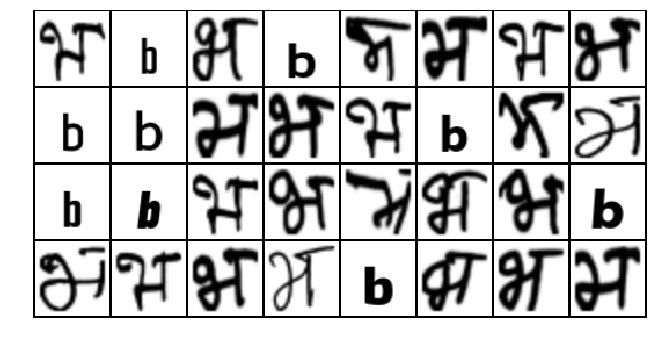

In [277]:
show(make_grid(real_cpu.cpu())) #show some real data

In [278]:
fake = netG(fixed_noise)
fake.data.size()

torch.Size([32, 3, 64, 64])

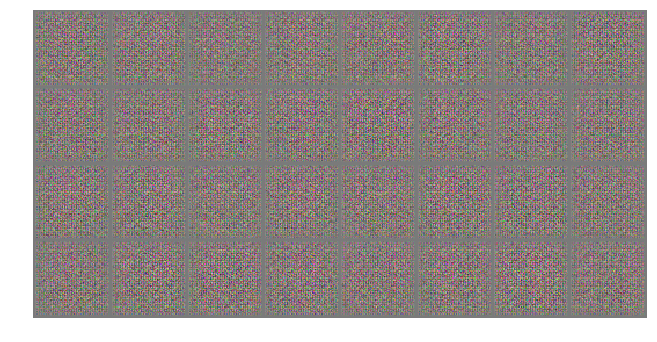

In [279]:
show(make_grid(fake.data.cpu())) # show some fake data. It should look bad for an untrained model

The below loop might take a while

In [280]:
use_cuda=True
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if use_cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        
        

        if i % 100 == 0:
            vutils.save_image(real_cpu,'%s/real_samples.png' % outf,normalize=True)
            fake = netG(fixed_noise)
            #show(make_grid(fake.data.cpu()))
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)


[0/35][0/102] Loss_D: 1.4078 Loss_G: 5.6171 D(x): 0.9790 D(G(z)): 0.6776 / 0.0052
[0/35][50/102] Loss_D: 0.0306 Loss_G: 19.5679 D(x): 0.9747 D(G(z)): 0.0000 / 0.0000
[0/35][100/102] Loss_D: 9.8222 Loss_G: 24.9719 D(x): 0.0006 D(G(z)): 0.0000 / 0.0000
[1/35][0/102] Loss_D: 0.0208 Loss_G: 5.6123 D(x): 0.9873 D(G(z)): 0.0048 / 0.0114
[1/35][50/102] Loss_D: 0.0264 Loss_G: 8.8250 D(x): 0.9759 D(G(z)): 0.0008 / 0.0006
[1/35][100/102] Loss_D: 0.1491 Loss_G: 4.3867 D(x): 0.9306 D(G(z)): 0.0637 / 0.0173
[2/35][0/102] Loss_D: 0.2419 Loss_G: 8.1951 D(x): 0.9736 D(G(z)): 0.1791 / 0.0006
[2/35][50/102] Loss_D: 0.0314 Loss_G: 8.1418 D(x): 0.9872 D(G(z)): 0.0179 / 0.0012
[2/35][100/102] Loss_D: 0.0030 Loss_G: 8.6186 D(x): 0.9974 D(G(z)): 0.0003 / 0.0003
[3/35][0/102] Loss_D: 0.3193 Loss_G: 20.8448 D(x): 0.9994 D(G(z)): 0.2386 / 0.0000
[3/35][50/102] Loss_D: 0.0007 Loss_G: 27.6310 D(x): 0.9993 D(G(z)): 0.0000 / 0.0000
[3/35][100/102] Loss_D: 0.0001 Loss_G: 27.6310 D(x): 0.9999 D(G(z)): 0.0000 / 0.0000

[32/35][50/102] Loss_D: 0.8214 Loss_G: 2.5183 D(x): 0.8263 D(G(z)): 0.3862 / 0.1220
[32/35][100/102] Loss_D: 0.4626 Loss_G: 2.1560 D(x): 0.7123 D(G(z)): 0.0857 / 0.1873
[33/35][0/102] Loss_D: 0.4309 Loss_G: 2.7979 D(x): 0.8017 D(G(z)): 0.1297 / 0.1061
[33/35][50/102] Loss_D: 0.2340 Loss_G: 2.8945 D(x): 0.8479 D(G(z)): 0.0583 / 0.0775
[33/35][100/102] Loss_D: 1.7390 Loss_G: 1.1050 D(x): 0.2870 D(G(z)): 0.0631 / 0.4194
[34/35][0/102] Loss_D: 0.7883 Loss_G: 2.3066 D(x): 0.6806 D(G(z)): 0.2735 / 0.1238
[34/35][50/102] Loss_D: 0.2679 Loss_G: 3.2219 D(x): 0.8358 D(G(z)): 0.0658 / 0.0654
[34/35][100/102] Loss_D: 0.1543 Loss_G: 3.7125 D(x): 0.8969 D(G(z)): 0.0329 / 0.0454


In [281]:
# do checkpointing
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

## Generate new images

In [282]:
noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
noise = noise.cuda()
noisev = Variable(noise)
fake = netG(noisev)
fake.size()

torch.Size([32, 3, 64, 64])

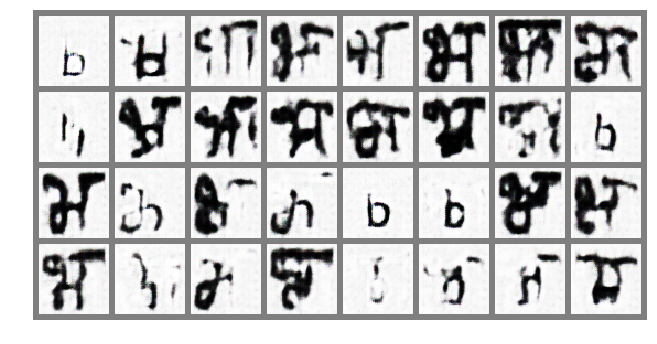

In [283]:
fake=fake.cpu()
show(make_grid(fake.data, padding=5))

In [284]:
import torchvision.transforms.functional as F

In [286]:
test = fake.data[31]

In [287]:
test


(0 ,.,.) = 
  0.8573  0.9250  0.9441  ...   0.9515  0.9622  0.8876
  0.9634  0.9641  0.9767  ...   0.9792  0.9806  0.9604
  0.9591  0.9771  0.9772  ...   0.9673  0.9718  0.9514
           ...             ⋱             ...          
  0.9790  0.9854  0.9628  ...   0.9651  0.9471  0.9404
  0.9832  0.9878  0.9840  ...   0.9539  0.9645  0.9424
  0.9289  0.9714  0.9377  ...   0.9275  0.9548  0.8426

(1 ,.,.) = 
  0.8128  0.9314  0.9323  ...   0.9439  0.9306  0.8451
  0.9427  0.9215  0.9675  ...   0.9643  0.9671  0.9639
  0.9682  0.9739  0.9663  ...   0.9826  0.9748  0.9587
           ...             ⋱             ...          
  0.9764  0.9885  0.9692  ...   0.9642  0.9411  0.9326
  0.9808  0.9905  0.9807  ...   0.9671  0.9447  0.9395
  0.9099  0.9612  0.9366  ...   0.9258  0.9396  0.8016

(2 ,.,.) = 
  0.8152  0.9369  0.9317  ...   0.9342  0.9407  0.9155
  0.9507  0.9550  0.9581  ...   0.9636  0.9767  0.9521
  0.9443  0.9664  0.9508  ...   0.9693  0.9687  0.9347
           ...            

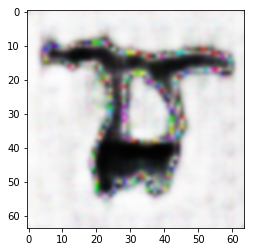

In [300]:
test=plt.imshow(transforms.ToPILImage()(fake.data[31]), interpolation="bicubic")

In [294]:
import cv2

ImportError: No module named cv2

In [298]:
import sys
!{sys.executable} -m pip install opencv-python


    100% |################################| 25.4MB 48kB/s  eta 0:00:01
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [299]:
import cv2

In [303]:
edges=cv2.Canny(test, 100, 200)

TypeError: Required argument 'threshold2' (pos 4) not found